In [1]:
from typing import List, Optional, Tuple, TypedDict, Annotated
from typing_extensions import TypedDict

from dotenv import load_dotenv

from langchain_community.chat_models import ChatOpenAI
from langchain_core.tools import tool
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain.output_parsers import PydanticOutputParser
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.chains import LLMChain
from api.src.models.dev.faiss_indexes import FlatIndex

from api.src.nlp import NLSPipeline

# Load env
load_dotenv()

# Load index
index = FlatIndex("recipe_embeddings.json")

/Users/Anaqi_Amir/opt/anaconda3/envs/FlavorFusion/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
2025-03-06 13:04:28.506613: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Anaqi_Amir/opt/anaconda3/envs/FlavorFusion/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
class NutritionFeatures(BaseModel):
    user_ingredients: List[str] = Field(default_factory=list)
    allergens: List[str] = Field(
        default_factory=list,
    )
    calories: Optional[Tuple[float, float]] = (None, None)
    total_fat: Optional[Tuple[float, float]] = (None, None)
    saturated_fat: Optional[Tuple[float, float]] = (None, None)
    carbs: Optional[Tuple[float, float]] = (None, None)
    sugar: Optional[Tuple[float, float]] = (None, None)
    sodium: Optional[Tuple[float, float]] = (None, None)
    protein: Optional[Tuple[float, float]] = (None, None)


def extract_nutritional_features(user_input: str) -> NutritionFeatures:
    """
    Extract nutritional features from a user's natural language input.
    """
    # Initialize the output parser using the Pydantic model.
    output_parser = PydanticOutputParser(pydantic_object=NutritionFeatures)

    # Retrieve format instructions that tell the LLM how to output the JSON.
    format_instructions = output_parser.get_format_instructions()

    # Create a system message to set the context.
    system_message = SystemMessagePromptTemplate.from_template(
        "You are an assistant that extracts nutritional features from user input, "
        "including recognized allergens from the following categories: tree nuts, peanut, milk, "
        "wheat, soy, fish, shellfish, eggs, sesame, pollen, sulfites."
    )

    # Create a human message prompt template that includes extraction instructions,
    # formatting instructions, and explicit allergen categorization.
    human_template = (
        "Extract the following nutritional features from the user's input. "
        "For numerical fields, return a reasonable range of number (or null if unspecified) that isn't too strict unless specified. "
        "For calories, return a generous range of numbers that are both above and below a specified number."
        "For list fields, return a JSON array of strings. "
        "Ensure that allergens are only taken from the following categories: "
        "tree nuts, peanut, milk, wheat, soy, fish, shellfish, eggs, sesame, pollen, sulfites. "
        "If the user does not specify any ingredients, feel free to be creative to add neccessary ingredients."
        "{format_instructions}\n\n"
        "User input: {user_input}"
    )
    human_message = HumanMessagePromptTemplate.from_template(human_template)

    # Build the full chat prompt.
    chat_prompt = ChatPromptTemplate.from_messages([system_message, human_message])

    # Initialize the ChatOpenAI model with a low temperature for deterministic output.
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.25, max_tokens=500)

    # Create the LLM chain with the prompt.
    chain = LLMChain(llm=llm, prompt=chat_prompt)

    # Run the chain by providing the user input and format instructions.
    response = chain.run(
        {"user_input": user_input, "format_instructions": format_instructions}
    )

    # Parse the LLM's response using our structured output parser.
    features = output_parser.parse(response)
    return features

## Easy Testing

In [ ]:
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, max_tokens=100)
AgentState = {}
AgentState["messages"] = []


def chatbot(state):
    messages = state["messages"]
    user_input = messages[-1]
    complete_query = (
        "Your task is to provide only the city name based on the user query. \
        Nothing more, just the city name mentioned. Following is the user query: "
        + user_input
    )
    response = llm.invoke(complete_query)
    print("In chatbot: " + response.content)
    state["messages"].append(response.content)
    return state


def get_info(state):
    messages = state["messages"]
    chatbot_response = messages[-1]
    complete_query = (
        "Your task is to find basic information of the city provided by the user. \
        Following is the user query: "
        + chatbot_response
    )
    response = llm.invoke(complete_query)
    print("In get_info: " + response.content)
    state["messages"].append(response.content)
    return state


def final_answer(state):
    messages = state["messages"]
    initial_user_query = messages[0]
    city_info = messages[-1]
    complete_query = (
        "Your task if to provide a concise answer based on the user query and the available info\
        User query: "
        + initial_user_query
        + "Information: "
        + city_info
    )
    response = llm.invoke(complete_query)
    print("In final_answer: " + response.content)
    return response.content


from langgraph.graph import Graph

# Define a Langchain graph
workflow = Graph()

workflow.add_node("chatbot", chatbot)
workflow.add_node("get_info", get_info)
workflow.add_node("final_answer", final_answer)

workflow.add_edge("chatbot", "get_info")
workflow.add_edge("get_info", "final_answer")

workflow.set_entry_point("chatbot")
workflow.set_finish_point("final_answer")

app = workflow.compile()

inputs = {"messages": ["how are you"]}
app.invoke(inputs)

In chatbot: Istanbul
In get_info: Istanbul is the largest city in Turkey and serves as the country's economic, cultural, and historic center. It is located in northwestern Turkey, straddling the Bosphorus Strait that separates Europe and Asia. Istanbul has a rich history that dates back thousands of years, with landmarks such as the Hagia Sophia, Blue Mosque, and Topkapi Palace. The city is known for its vibrant markets, delicious cuisine, and bustling street life. Istanbul is also a major tourist destination, attracting
In final_answer: Istanbul is the largest city in Turkey, located in northwestern Turkey and serving as the country's economic, cultural, and historic center. It has a rich history dating back thousands of years, with landmarks such as the Hagia Sophia, Blue Mosque, and Topkapi Palace. The city is known for its vibrant markets, delicious cuisine, and bustling street life.


"Istanbul is the largest city in Turkey, located in northwestern Turkey and serving as the country's economic, cultural, and historic center. It has a rich history dating back thousands of years, with landmarks such as the Hagia Sophia, Blue Mosque, and Topkapi Palace. The city is known for its vibrant markets, delicious cuisine, and bustling street life."

## James Briggs

In [ ]:
from typing import TypedDict, Annotated, List, Union
from typing_extensions import TypedDict

from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel

import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

class NutritionFeatures(BaseModel):
    user_ingredients: List[str] = Field(default_factory=list)
    allergens: List[str] = Field(default_factory=list,)
    calories: Optional[Tuple[float, float]] = ( None,None)
    total_fat: Optional[Tuple[float, float]] = (None,None)
    saturated_fat: Optional[Tuple[float, float]] = (None,None)
    carbs: Optional[Tuple[float, float]] = (None,None)
    sugar: Optional[Tuple[float, float]] = (None,None)
    sodium: Optional[Tuple[float, float]] = (None, None)
    protein: Optional[Tuple[float, float]] = (None,None)

def extract_nutritional_features(user_input: str) -> NutritionFeatures:
    """
    Extract nutritional features from a user's natural language input.
    """
    # Initialize the output parser using the Pydantic model.
    output_parser = PydanticOutputParser(pydantic_object=NutritionFeatures)

    # Retrieve format instructions that tell the LLM how to output the JSON.
    format_instructions = output_parser.get_format_instructions()

    # Create a system message to set the context.
    system_message = SystemMessagePromptTemplate.from_template(
        "You are an assistant that extracts nutritional features from user input, "
        "including recognized allergens from the following categories: tree nuts, peanut, milk, "
        "wheat, soy, fish, shellfish, eggs, sesame, pollen, sulfites."
    )

    # Create a human message prompt template that includes extraction instructions,
    # formatting instructions, and explicit allergen categorization.
    human_template = (
        "Extract the following nutritional features from the user's input. "
        "For numerical fields, return a reasonable range of number (or null if unspecified) that isn't too strict unless specified. "
        "For calories, return a generous range of numbers that are both above and below a specified number."
        "For list fields, return a JSON array of strings. "
        "Ensure that allergens are only taken from the following categories: "
        "tree nuts, peanut, milk, wheat, soy, fish, shellfish, eggs, sesame, pollen, sulfites. "
        "If the user does not specify any ingredients, feel free to be creative to add neccessary ingredients."
        "{format_instructions}\n\n"
        "User input: {user_input}"
    )
    human_message = HumanMessagePromptTemplate.from_template(human_template)

    # Build the full chat prompt.
    chat_prompt = ChatPromptTemplate.from_messages([system_message, human_message])

    # Initialize the ChatOpenAI model with a low temperature for deterministic output.
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.25, max_tokens=500)

    # Create the LLM chain with the prompt.
    chain = LLMChain(llm=llm, prompt=chat_prompt)

    # Run the chain by providing the user input and format instructions.
    response = chain.run(
        {"user_input": user_input, "format_instructions": format_instructions}
    )

    # Parse the LLM's response using our structured output parser.
    features = output_parser.parse(response)
    return features

@tool("recipe_recommender")
def recipe_recommender(state: AgentState):
    """Takes in user input, extracts relevant features, and output recommended recipes from database"""
    messages = state['messages']
    last_message = messages[-1] # this has the query we need to send to the tool provided by the agent

    extracted_features = extract_nutritional_features(last_message)

    recs = index.recommend_recipes(
        user_ingredients=extracted_features.user_ingredients,
        calories=extracted_features.calories,
        total_fat=extracted_features.total_fat,
        protein=extracted_features.protein,
    )

    return {"messages": [' '.join(recs)]}

@tool("final_answer")
def final_answer()

system_prompt = """
    You are a chatbot for a recipe recommender appplication. Your tasks is to communicate with the user and try to figure out what type of recipes they want
    in as little time as possible. Try your best to ensure that the user provide at least a few ingredients that they like for better recommendations.
    If they insist on not giving you any ingredients, then feel free to be creative.

    Be aware of nutritional restrictions that the user's are providing as well.

    Most importantly, try to ask the users if they are allergic to anything.

    Finally, if the user is not providing you information of the task at hand, be friendly and prompt them to include the relevant details.
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
])

In [ ]:
from langchain_core.messages import ToolCall, ToolMessage

llm = ChatOpenAI(model="gpt-4o", temperature=0, max_tokens=500)

tools = [recipe_recommender]

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

/var/folders/5q/n8ssmgtj6nd825347vg7wz240000gn/T/ipykernel_66469/1561615205.py:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


NotImplementedError: 

In [ ]:
inputs = {
    "input": "please give me a high protein meal that has chicken in it.",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)
out

## AI with Misbah

In [ ]:
# # Define the output schema using a Pydantic model.
# from typing import Sequence
# import operator
# from langchain_core.messages import BaseMessage

# class NutritionFeatures(BaseModel):
#     user_ingredients: List[str] = Field(default_factory=list)
#     allergens: List[str] = Field(default_factory=list,)
#     calories: Optional[Tuple[float, float]] = ( None,None)
#     total_fat: Optional[Tuple[float, float]] = (None,None)
#     saturated_fat: Optional[Tuple[float, float]] = (None,None)
#     carbs: Optional[Tuple[float, float]] = (None,None)
#     sugar: Optional[Tuple[float, float]] = (None,None)
#     sodium: Optional[Tuple[float, float]] = (None, None)
#     protein: Optional[Tuple[float, float]] = (None,None)

# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], operator.add]


# def extract_nutritional_features(user_input: str) -> NutritionFeatures:
#     """
#     Extract nutritional features from a user's natural language input.
#     """
#     # Initialize the output parser using the Pydantic model.
#     output_parser = PydanticOutputParser(pydantic_object=NutritionFeatures)

#     # Retrieve format instructions that tell the LLM how to output the JSON.
#     format_instructions = output_parser.get_format_instructions()

#     # Create a system message to set the context.
#     system_message = SystemMessagePromptTemplate.from_template(
#         "You are an assistant that extracts nutritional features from user input, "
#         "including recognized allergens from the following categories: tree nuts, peanut, milk, "
#         "wheat, soy, fish, shellfish, eggs, sesame, pollen, sulfites."
#     )

#     # Create a human message prompt template that includes extraction instructions,
#     # formatting instructions, and explicit allergen categorization.
#     human_template = (
#         "Extract the following nutritional features from the user's input. "
#         "For numerical fields, return a reasonable range of number (or null if unspecified) that isn't too strict unless specified. "
#         "For calories, return a generous range of numbers that are both above and below a specified number."
#         "For list fields, return a JSON array of strings. "
#         "Ensure that allergens are only taken from the following categories: "
#         "tree nuts, peanut, milk, wheat, soy, fish, shellfish, eggs, sesame, pollen, sulfites. "
#         "If the user does not specify any ingredients, feel free to be creative to add neccessary ingredients."
#         "{format_instructions}\n\n"
#         "User input: {user_input}"
#     )
#     human_message = HumanMessagePromptTemplate.from_template(human_template)

#     # Build the full chat prompt.
#     chat_prompt = ChatPromptTemplate.from_messages([system_message, human_message])

#     # Initialize the ChatOpenAI model with a low temperature for deterministic output.
#     llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.25, max_tokens=500)

#     # Create the LLM chain with the prompt.
#     chain = LLMChain(llm=llm, prompt=chat_prompt)

#     # Run the chain by providing the user input and format instructions.
#     response = chain.run(
#         {"user_input": user_input, "format_instructions": format_instructions}
#     )

#     # Parse the LLM's response using our structured output parser.
#     features = output_parser.parse(response)
#     return features

In [ ]:
# from langchain_core.utils.function_calling import convert_to_openai_function
# # from langgraph.prebuilt import ToolInvocation
# # from langchain_core.messages import FunctionMessage
# # from langgraph.prebuilt import ToolExecutor
# # import json

# from models.dev.faiss_indexes import FlatIndex

# index = FlatIndex("recipe_embeddings.json")

# # tools = [extract_nutritional_features()]

# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5, max_tokens=200)
# # functions = [convert_to_openai_function(t) for t in tools]
# # model = llm.bind_functions(functions)

# def chatbot(state: AgentState):
#     messages = state['messages']
#     response = llm.invoke(messages)
#     return {"messages": [response]}

# def recipe_recommender(state: AgentState):
#     messages = state['messages']
#     last_message = messages[-1] # this has the query we need to send to the tool provided by the agent

#     extracted_features = extract_nutritional_features(last_message)

#     recs = index.recommend_recipes(
#         user_ingredients=extracted_features.user_ingredients,
#         calories=extracted_features.calories,
#         total_fat=extracted_features.total_fat,
#         protein=extracted_features.protein,
#     )

#     return {"messages": [' '.join(recs)]}

# graph = StateGraph(AgentState)

# graph.add_node("chatbot", chatbot)
# graph.add_node("recommender", recipe_recommender)

# graph.add_edge("chatbot", "recommender")

# graph.set_entry_point("chatbot")
# graph.add_edge("recommender", END)

# app = graph.compile()

/Users/Anaqi_Amir/opt/anaconda3/envs/FlavorFusion/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# from langchain_core.messages import HumanMessage

# inputs = {"messages": [HumanMessage(content="Please give a chicken recipe")]}
# for output in app.stream(inputs):
#     # stream() yields dictionaries with output keyed by node name
#     for key, value in output.items():
#         print(f"Output from node '{key}':")
#         print("---")
#         print(value)
#     print("\n---\n")

Output from node 'chatbot':
---
{'messages': [AIMessage(content="Sure! Here's a simple and delicious recipe for **Garlic Butter Chicken Thighs**. It’s easy to make and packed with flavor.\n\n### Garlic Butter Chicken Thighs\n\n#### Ingredients:\n- 4 bone-in, skin-on chicken thighs (you can also use boneless, skinless if preferred)\n- Salt and pepper, to taste\n- 2 tablespoons olive oil\n- 4 tablespoons unsalted butter\n- 4 cloves garlic, minced\n- 1 teaspoon dried thyme (or 1 tablespoon fresh thyme)\n- 1 teaspoon paprika (optional)\n- Juice of 1 lemon\n- Fresh parsley, chopped (for garnish)\n\n#### Instructions:\n\n1. **Prep the Chicken:**\n   - Pat the chicken thighs dry with paper towels. Season both sides generously with salt and pepper. If using paprika, sprinkle it on as well.\n\n2. **Sear the Chicken:**\n   - In a large skillet, heat the olive oil over medium-high heat. Once hot", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 200, 'prompt_tokens': 

/var/folders/5q/n8ssmgtj6nd825347vg7wz240000gn/T/ipykernel_29061/808559875.py:63: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = chain.run(


Output from node 'recommender':
---
{'messages': ['bacon roasted chicken with potatoes chicken danny style creamed chicken and corn soup chicken and eggplant  aubergine   pseudo fried creamy chicken taco soup']}

---



## LangChain

In [9]:
# graph_builder = StateGraph(AgentState)

# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5, max_tokens=200)

# tools = [extract_nutritional_features]
# llm_with_tools = llm.bind_tools(tools)

# def chatbot(state: State):
#     return {"messages": [llm_with_tools.invoke(state["messages"])]}


# graph_builder.add_node("chatbot", chatbot)

# # tool_node = ToolNode(tools=tools)
# graph_builder.add_node("tools", extract_nutritional_features)


# # graph_builder.add_conditional_edges(
# #     "chatbot",
# #     tools_condition,
# # )
# # Any time a tool is called, we return to the chatbot to decide the next step
# graph_builder.add_edge("chatbot", "tools")
# graph_builder.add_edge("tools", END)
# graph_builder.set_entry_point("chatbot")
# graph = graph_builder.compile()

In [11]:
# def stream_graph_updates(user_input: str):
#     for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
#         for value in event.values():
#             print("Assistant:", value["messages"][-1].content)


# while True:
#     try:
#         user_input = input("User: ")
#         if user_input.lower() in ["quit", "exit", "q"]:
#             print("Goodbye!")
#             break

#         stream_graph_updates(user_input)
#     except:
#         # fallback if input() is not available
#         user_input = "What do you know about LangGraph?"
#         print("User: " + user_input)
#         stream_graph_updates(user_input)
#         break

In [ ]:
# from IPython.display import Image, display

# try:
#     display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception:
#     # This requires some extra dependencies and is optional
#     pass

## My BS

In [6]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langchain_openai.chat_models import ChatOpenAI

from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

from api.src.nlp.NLSPipeline import NutritionFeatures, extract_nutritional_features
from api.src.models.dev.faiss_indexes import FlatIndex

from dotenv import load_dotenv
from typing import Dict

# Load env
load_dotenv()

# Load index
index = FlatIndex("recipe_embeddings.json")

/Users/Anaqi_Amir/opt/anaconda3/envs/FlavorFusion/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
from typing import Dict


@tool("recipe_recommender")
def recipe_recommender(q: str) -> Dict:
    """Takes in user input, extracts relevant features, and output recommended recipes from database"""
    print(f"Parsed user input: {q}")

    extracted_features = extract_nutritional_features(q)

    recs = index.recommend_recipes(
        user_ingredients=extracted_features.user_ingredients,
        allergens=extracted_features.allergens,
        calories=extracted_features.calories,
        total_fat=extracted_features.total_fat,
        protein=extracted_features.protein,
        saturated_fat=extracted_features.saturated_fat,
        carbs=extracted_features.carbs,
        sodium=extracted_features.sodium,
        sugar=extracted_features.sugar,
        top_n=10,
    )

    return {"messages": [" ".join(recs)]}


@tool("final_answer")
def final_answer(recommendations: Dict) -> Dict:
    """Formats the query into a final answer"""
    return recommendations


tools = [recipe_recommender, final_answer]
tool_node = ToolNode(tools)


def router(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "recommender"
    return END


def chatbot(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.25, max_tokens=500).bind_tools(
    tools
)

tool_node.invoke(
    {
        "messages": [
            llm.invoke(
                "Recommend me a recipe with around 500 calories, low fat (no more than 10g total fat), high protein, \n"
                "and please avoid macadamia nuts and whey protein. I love tomatoes and basil, but I don't like onions."
            )
        ]
    }
)

# graph = StateGraph(MessagesState)

# graph.add_node("chatbot", chatbot)
# graph.add_node("recommender", recipe_recommender)
# graph.add_node("final_answer", final_answer)

# graph.add_edge(START, "chatbot")
# # graph.add_conditional_edges("chatbot", router, ["recommender", END])
# graph.add_edge("chatbot", "recommender")
# graph.add_edge("recommender", "final_answer")
# graph.add_edge("final_answer", END)

# app = graph.compile()

Parsed user input: 500 calories, low fat, high protein, no macadamia nuts, no whey protein, tomatoes, basil, no onions
Response:
{
    "user_ingredients": ["tomatoes", "basil", "onions"],
    "allergens": ["tree nuts", "milk"],
    "calories": [500, 500],
    "total_fat": [null, null],
    "saturated_fat": [null, null],
    "carbs": [null, null],
    "sugar": [null, null],
    "sodium": [null, null],
    "protein": [null, null]
}



{'messages': [ToolMessage(content='{"messages": ["molasses crinkles molasses crinkles molasses crinkles molasses crinkles molasses crinkles molasses crinkles molasses crinkles molasses crinkles molasses crinkles molasses crinkles"]}', name='recipe_recommender', tool_call_id='call_nOPd10K5Z0MsD7MgW0EPNLLc')]}

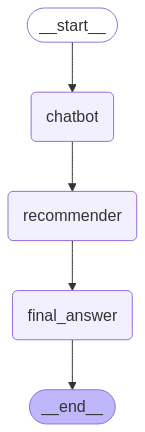

In [4]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
for chunk in app.stream(
    {
        "messages": [
            (
                "human",
                "Recommend me a recipe with around 500 calories, low fat (no more than 10g total fat), high protein, \n"
                "and please avoid macadamia nuts and whey protein. I love tomatoes and basil, but I don't like onions.",
            )
        ]
    },
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Recommend me a recipe with around 500 calories, low fat (no more than 10g total fat), high protein, 
and please avoid macadamia nuts and whey protein. I love tomatoes and basil, but I don't like onions.
================================== Ai Message ==================================
Tool Calls:
  recipe_recommender (call_vw4Bh8fN6Dt5vTls0Zqj1BnU)
 Call ID: call_vw4Bh8fN6Dt5vTls0Zqj1BnU
  Args:
    q: 500 calories, low fat, high protein, no macadamia nuts, no whey protein, tomatoes, basil, no onions


ValidationError: 1 validation error for recipe_recommender
q
  Field required [type=missing, input_value={'messages': [HumanMessag...: 0, 'reasoning': 0}})]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing

# Custom Code

In [ ]:
# Define your tools
@tool
def recommend_recipes(q: str) -> str:
    """Takes in user input, extracts relevant features, and output recommended recipes from database"""

    print(f"\n Parsed user input: \n {q} \n")

    extracted_features = extract_nutritional_features(q)

    print(f"\n Extracted features: \n {extracted_features} \n")

    recs = index.recommend_recipes(
        user_ingredients=extracted_features.user_ingredients,
        allergens=extracted_features.allergens,
        calories=extracted_features.calories,
        total_fat=extracted_features.total_fat,
        protein=extracted_features.protein,
        saturated_fat=extracted_features.saturated_fat,
        carbs=extracted_features.carbs,
        sodium=extracted_features.sodium,
        sugar=extracted_features.sugar,
        top_n=10,
    )

    print(f"\n recs: \n {recs} \n")

    return ", ".join(recs)


@tool
def final_answer(answer: str) -> str:
    """Useful for providing the final answer to the user."""
    return answer


tools = [recommend_recipes, final_answer]

# Define the LLM
llm = ChatOpenAI(temperature=0.7)

# Define the agent
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are a recipe recommendation program that takes in user inputs
            and outputs a list of recipes. If a user does not provide enough information
            on what recipes they want, you will keep on asking them about it until
            you have enough information to get a good recommendation for the user.
            """,
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{query}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)
agent = create_tool_calling_agent(llm=llm, prompt=prompt, tools=tools)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


# Define the LangGraph state
class AgentState(TypedDict):
    messages: List[Any]
    ingredients: Optional[str]
    nutrition: Optional[str]
    recipes: Optional[str]


# Define the nodes
def agent_node(state: AgentState) -> Dict:
    query = state["messages"][-1]
    chat_history = state["messages"][:1]
    print(f"agent_node: query = {query}")
    print(f"agent_node: chat_history = {chat_history}")
    result = agent_executor.invoke({"query": query, "chat_history": chat_history})
    print(f"agent_node: result = {result}")
    output = {"messages": state["messages"] + [AIMessage(content=result["output"])]}
    print(f"agent_node: output = {output}")
    return output


def recommendation_node(state: AgentState):
    print(f"recommend_node: state = {state}")
    result = recommend_recipes.run(
        ingredients=state["ingredients"], nutrition=state["nutrition"]
    )
    return {
        "messages": state["messages"]
        + [AIMessage(content=f"Here are some recommended recipes: {result}")],
        "recipes": result,
    }


def final_answer_node(state: AgentState) -> Dict:
    print(f"final_answer_node: state = {state}")
    result = final_answer.run(answer=state["messages"][-1])
    return {"messages": state["messages"] + [AIMessage(content=result)]}


# Define router
def router(state: AgentState):
    if "recommend_recipes" in state["messages"][-1]:
        return "recommend"
    elif "final_answer" in state["messages"][-1]:
        return "final"
    else:
        return "agent"


# Define the graph
workflow = StateGraph(AgentState)
workflow.add_node("agent", agent_node)
workflow.add_node("recommendation_tool", recommendation_node)
workflow.add_node("final_answer_tool", final_answer_node)

# Set up the edges
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    router,
    {
        "recommend": "recommendation_tool",
        "final": "final_answer_tool",
        "agent": "agent",
    },
)
workflow.add_edge("recommendation_tool", "agent")
workflow.add_edge("final_answer_tool", END)

# Compile the graph
app = workflow.compile()

# Example usage
# inputs = {
#     "messages": [
#         HumanMessage(
#             content="I'm looking for healthy recipes with chicken and low carbs."
#         )
#     ],
#     "ingredients": "chicken, garlic, honey",
#     "nutrition": "High protein",
#     "recipes": "Honey garlic chicken",
# }
inputs = AgentState(
    # messages=["I'm looking for healthy recipes with chicken and low carbs"]
    messages=[
        "Please recommend recipes that are healthy are have chicken. I want it to have low carbs too."
    ]
)
result = app.invoke(inputs)
print(result)

# inputs2 = {"messages": [HumanMessage(content="Hi, how are you?")]}
# result2 = app.invoke(inputs2)
# print(result2)

# inputs3 = {"messages": [HumanMessage(content="I need recipes with beef and high protein")]}
# result3 = app.invoke(inputs3)
# print(result3)

# The other James Briggs implementation

In [ ]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.prebuilt import ToolNode
import operator


# Define state
class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]


# Define tools
@tool
def recommend_recipes(q: str) -> str:
    """Takes in user input, extracts relevant features, and output recommended recipes from database"""

    print(f"\n Parsed user input: \n {q} \n")

    extracted_features = extract_nutritional_features(q)

    print(f"\n Extracted features: \n {extracted_features} \n")

    recs = index.recommend_recipes(
        user_ingredients=extracted_features.user_ingredients,
        allergens=extracted_features.allergens,
        calories=extracted_features.calories,
        total_fat=extracted_features.total_fat,
        protein=extracted_features.protein,
        saturated_fat=extracted_features.saturated_fat,
        carbs=extracted_features.carbs,
        sodium=extracted_features.sodium,
        sugar=extracted_features.sugar,
        top_n=10,
    )

    print(f"\n recs: \n {recs} \n")

    return ", ".join(recs)


@tool
def final_answer(answer: str) -> str:
    """Useful for providing the final answer to the user."""
    print("Hi im the final answer")
    return answer


# Define tool node
tools = [recommend_recipes, final_answer]
tool_node = ToolNode(tools)  # A single node that contains all the tools


# Define llm
llm = ChatOpenAI()


# Define prompt
system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

You are also recipe recommendation program that takes in user inputs
and outputs a list of recipes. If a user does not provide enough information
on what recipes they want, you will keep on asking them about it until
you have enough information to get a good recommendation for the user.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="chat_history"),
        ("user", "{input}"),
        ("assistant", "scratchpad: {scratchpad}"),
    ]
)


# Define scratchpad
def create_scratchpad(intermediate_steps: list[AgentAction]):
    """
    Creates a scratchpad displaying the step-by-step input and output between Human and Agent Messsages.
    """
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)


# Define agent
agent = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

# Test run
inputs = {
    "input": "please give me a breakfast recipe with eggs but no milk",
    "chat_history": [],
    "intermediate_steps": [],
}
out = agent.invoke(inputs)
out

In [ ]:
def agent_node(state: AgentState) -> AgentState:
    """
    Agent node that decides which action to take and which tools to use.
    """
    print("run_agent")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = agent.invoke(state)
    tool_name = out.tool_calls[0]["name"]  # Get name of tool
    tool_args = out.tool_calls[0]["args"]  # Get args that were passed to the tool
    action_out = AgentAction(tool=tool_name, tool_input=tool_args, log="TBD")
    return {"intermediate_steps": [action_out]}


def router(state: AgentState) -> str:
    """
    Returns a string of the name of the tool that is to be used.
    """
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"


tool_str_to_func = {
    "recommend_recipes": recommend_recipes,
    "final_answer": final_answer,
}


def tools_node(state: AgentState) -> AgentState:
    """
    Tool node that invokes the chosen tool.
    """
    # use this as helper function so we repeat less code
    temp = state["intermediate_steps"]
    print(f"tools_node intermediate steps: {temp}")
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(tool=tool_name, tool_input=tool_args, log=str(out))
    print(f"action_out: {action_out}")
    return {"intermediate_steps": [action_out]}

In [ ]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("agent", agent_node)
graph.add_node("recommend_recipes", tools_node)
graph.add_node("final_answer", tools_node)

graph.set_entry_point("agent")

graph.add_conditional_edges(
    source="agent",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "agent")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

In [ ]:
from IPython.display import Image, display

try:
    display(Image(runnable.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
out = runnable.invoke(
    {
        "input": "i want a chicken rice recipe with calories between 0-2000, total fat between 0-1000, saturated fat between 0-1000, carbs between 0-1000, sugar between 0-200, sodium between 0-500mg, and protein between 0-200",
        "chat_history": [],
    }
)

print("\n\nFinal output:")
out

In [ ]:
from langchain_core.messages import HumanMessage
import pprint


# TODO
# Currently, you're simply passing all HumanMessages into the chat history. You must update the ChatHistory with AIMesssages
# 1) Figure out which stream_mode to use
# 2) What elements to get the assistent_message
def stream_graph_updates(user_input: str, state: AgentState):
    state["chat_history"].append(HumanMessage(content=user_input))
    print("hi im here")

    for event in runnable.stream(
        {
            "input": user_input,
            "chat_history": state["chat_history"],
            "intermediate_steps": state["intermediate_steps"],
        },
        stream_mode="values",
    ):
        print(f"event: {event}")
        assistant_message = event["chat_history"][-1].content
        print("Assistant:", assistant_message)
        state["chat_history"].append(AIMessage(content=assistant_message))


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        # Initialize state if first interaction
        if "state" not in locals():
            state = {"input": user_input, "chat_history": [], "intermediate_steps": []}

        print(state)

        stream_graph_updates(user_input, state)
    except Exception as e:
        print(f"Error: {e}")
        break

In [ ]:
from langchain_core.messages import HumanMessage


# TODO
# Currently, you're simply passing all HumanMessages into the chat history. You must update the ChatHistory with AIMesssages
# 1) Figure out which stream_mode to use
# 2) What elements to get the assistent_message
def stream_graph_updates(user_input: str, state: AgentState) -> None:
    # state["chat_history"].append(HumanMessage(content=user_input))
    print(f"state before update: {state}")
    state["input"] = user_input
    state["chat_history"].append(HumanMessage(content=user_input))
    print(f"state after user_input update: {state} \n")

    events = runnable.stream(state, stream_mode="values")

    for event in events:
        print(f"event: {event}")
        print(f"event['intermediate_steps]: {event['intermediate_steps']}")
        if len(event["intermediate_steps"]) != 0:
            if event["intermediate_steps"][-1].tool == "final_answer":
                print("here")
                output = event["intermediate_steps"][-1].tool_input["answer"]
                state["chat_history"].append(AIMessage(output))
                print(f"output: {output}")


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        # Initialize state if first interaction
        if "state" not in locals():
            state = {"input": user_input, "chat_history": [], "intermediate_steps": []}

        print(f"user_input: {user_input}")

        stream_graph_updates(user_input, state)
    except Exception as e:
        print(f"Error: {e}")
        break